In [1]:
from db_connection import create_connection, query_data, query_sql_file, select_table
from preprocessing import process_admissions, process_patients, process_transfers, apply_feature_importance


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Connect to the MIMIC-III database
con = create_connection()

In [4]:
img_path = '../data_viz_img/patient_stay/'
dataset_path = '../dataset/'

# Admissions

In [5]:
admissions = select_table('admissions', con)
admissions.head()

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,None,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,None,CATHOLIC,MARRIED,WHITE,NaT,NaT,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaT,NaT,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,None,PROTESTANT QUAKER,SINGLE,WHITE,NaT,NaT,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,None,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [6]:
admissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   row_id                58976 non-null  int64         
 1   subject_id            58976 non-null  int64         
 2   hadm_id               58976 non-null  int64         
 3   admittime             58976 non-null  datetime64[ns]
 4   dischtime             58976 non-null  datetime64[ns]
 5   deathtime             5854 non-null   datetime64[ns]
 6   admission_type        58976 non-null  object        
 7   admission_location    58976 non-null  object        
 8   discharge_location    58976 non-null  object        
 9   insurance             58976 non-null  object        
 10  language              33644 non-null  object        
 11  religion              58518 non-null  object        
 12  marital_status        48848 non-null  object        
 13  ethnicity       

#### Check missing data in Admissions

In [7]:
# check null values
admissions.isnull().sum()

row_id                      0
subject_id                  0
hadm_id                     0
admittime                   0
dischtime                   0
deathtime               53122
admission_type              0
admission_location          0
discharge_location          0
insurance                   0
language                25332
religion                  458
marital_status          10128
ethnicity                   0
edregtime               28099
edouttime               28099
diagnosis                  25
hospital_expire_flag        0
has_chartevents_data        0
dtype: int64

> ##### Features with missing data:
> **deathtime** - means patient survived
> **language, religion, marital_status** - irrelevant features
> **diagnoses** - preliminary diagnosis, not very important
> **edregtime, edouttime** - emergency admit time, means patient was not admittied to emergency

#### Check Admission Locations

In [8]:
admissions.admission_location.value_counts()

EMERGENCY ROOM ADMIT         22754
PHYS REFERRAL/NORMAL DELI    15079
CLINIC REFERRAL/PREMATURE    12032
TRANSFER FROM HOSP/EXTRAM     8456
TRANSFER FROM SKILLED NUR      273
** INFO NOT AVAILABLE **       204
HMO REFERRAL/SICK              102
TRANSFER FROM OTHER HEALT       71
TRSF WITHIN THIS FACILITY        5
Name: admission_location, dtype: int64

#### Group all TRANSFER admissions into a single category

In [9]:
admissions = process_admissions.group_admission_location(admissions)
admissions.admission_location.value_counts()

EMERGENCY ROOM ADMIT         22754
PHYS REFERRAL/NORMAL DELI    15079
CLINIC REFERRAL/PREMATURE    12032
TRANSFER                      8805
** INFO NOT AVAILABLE **       204
HMO REFERRAL/SICK              102
Name: admission_location, dtype: int64

#### Handling \*\*INFO NOT AVAILABLE\*\* category
> At first, we will just rename into 'OTHER' category.

In [10]:
admissions['admission_location'].replace('** INFO NOT AVAILABLE **', 'OTHER', inplace=True)

#### Check Admission Types

In [11]:
admissions.admission_type.value_counts()

EMERGENCY    42071
NEWBORN       7863
ELECTIVE      7706
URGENT        1336
Name: admission_type, dtype: int64

##### Re-group Admission Types

In [12]:
admissions = process_admissions.group_admission_type(admissions)
admissions.admission_type.value_counts()

EMERGENCY    43407
NEWBORN       7863
ELECTIVE      7706
Name: admission_type, dtype: int64

#### Contingency Table: Admission Location vs. Admission Type

In [13]:
# cross_tab_script = '../sql_scripts/admissions_cross_tab.sql'
# query_list = query_sql_file(cross_tab_script, con)
#
# admission_locations = query_data(query_list[0], con)
# admission_types = query_data(query_list[1], con)
#
# pivot_table = query_data(query_list[2], con)

pivot_table = pd.crosstab(admissions['admission_location'], admissions['admission_type'])
pivot_table

admission_type,ELECTIVE,EMERGENCY,NEWBORN
admission_location,,,
CLINIC REFERRAL/PREMATURE,25,10020,1987
EMERGENCY ROOM ADMIT,0,22754,0
HMO REFERRAL/SICK,0,1,101
OTHER,0,5,199
PHYS REFERRAL/NORMAL DELI,7646,1880,5553
TRANSFER,35,8747,23


In [14]:
sorted_table = pivot_table.loc[pivot_table.sum(axis=1).sort_values(ascending=False).index]
sorted_table

admission_type,ELECTIVE,EMERGENCY,NEWBORN
admission_location,,,
EMERGENCY ROOM ADMIT,0,22754,0
PHYS REFERRAL/NORMAL DELI,7646,1880,5553
CLINIC REFERRAL/PREMATURE,25,10020,1987
TRANSFER,35,8747,23
OTHER,0,5,199
HMO REFERRAL/SICK,0,1,101


#### Total Admissions by Admit. Location & Admit. Type

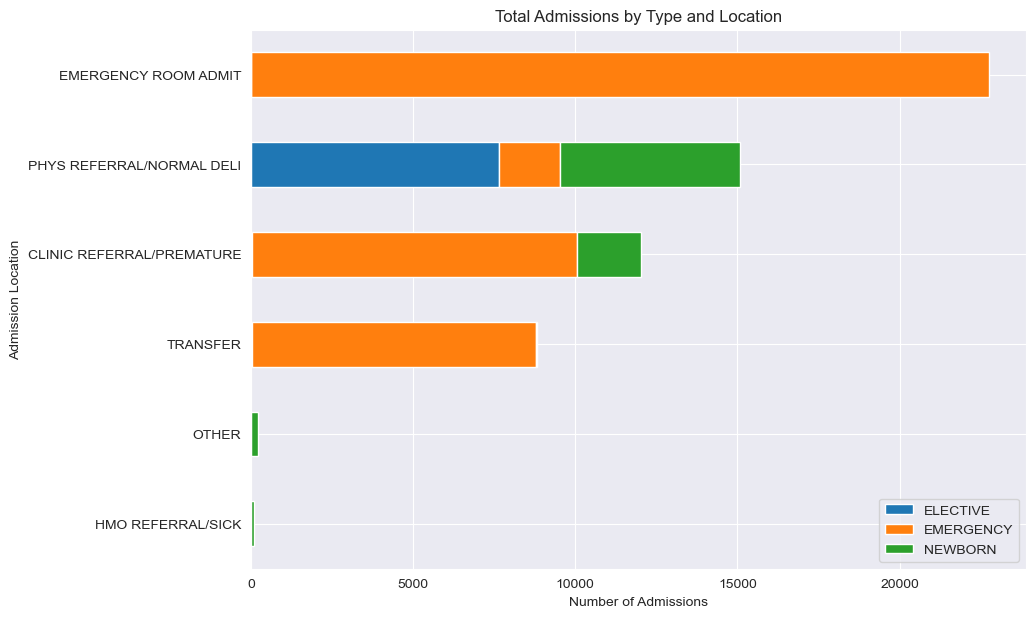

In [15]:
ax = sorted_table.plot(kind='barh', stacked=True, figsize=(10, 7))
ax.invert_yaxis()
plt.xlabel('Number of Admissions')
plt.ylabel('Admission Location')
plt.title('Total Admissions by Type and Location')
plt.legend(loc='lower right', bbox_to_anchor=(1, 0))
plt.savefig(f'{img_path}01_Admission by Type and Location.png')
plt.show()

## Demographics
#### Check Ethnicity

In [16]:
admissions.ethnicity.unique()

array(['WHITE', 'UNKNOWN/NOT SPECIFIED', 'MULTI RACE ETHNICITY',
       'BLACK/AFRICAN AMERICAN', 'HISPANIC OR LATINO',
       'PATIENT DECLINED TO ANSWER', 'ASIAN', 'OTHER',
       'HISPANIC/LATINO - GUATEMALAN', 'ASIAN - VIETNAMESE',
       'AMERICAN INDIAN/ALASKA NATIVE', 'WHITE - RUSSIAN',
       'HISPANIC/LATINO - PUERTO RICAN', 'ASIAN - CHINESE',
       'ASIAN - ASIAN INDIAN', 'BLACK/AFRICAN',
       'HISPANIC/LATINO - SALVADORAN', 'HISPANIC/LATINO - DOMINICAN',
       'UNABLE TO OBTAIN', 'BLACK/CAPE VERDEAN', 'BLACK/HAITIAN',
       'WHITE - OTHER EUROPEAN', 'PORTUGUESE', 'SOUTH AMERICAN',
       'WHITE - EASTERN EUROPEAN', 'CARIBBEAN ISLAND', 'ASIAN - FILIPINO',
       'ASIAN - CAMBODIAN', 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)',
       'WHITE - BRAZILIAN', 'ASIAN - KOREAN',
       'HISPANIC/LATINO - COLOMBIAN', 'ASIAN - JAPANESE',
       'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'ASIAN - THAI',
       'HISPANIC/LATINO - HONDURAN', 'HISPANIC/LATINO - CUBAN',
       'MID

##### Re-group ethnicity

In [17]:
admissions = process_admissions.group_ethnicities(admissions)
admissions.ethnicity.value_counts()

WHITE                   41386
OTHER/UNKNOWN            7408
BLACK                    5785
HISPANIC/LATINO          2128
ASIAN                    2050
MULTI RACE ETHNICITY      130
NATIVE AMERICAN            54
ISLANDER                   35
Name: ethnicity, dtype: int64

### Check Patient Outcome (Alive/Deceased) grouped by Ethnicity

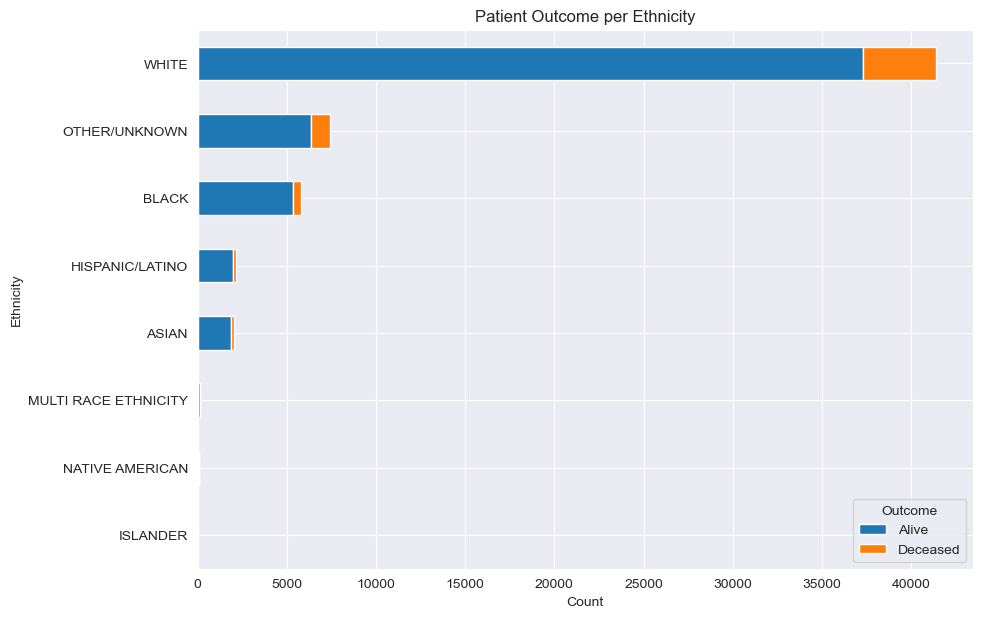

In [18]:
outcome_counts = admissions.groupby(['ethnicity', 'hospital_expire_flag']).size().unstack()
sorted_counts = outcome_counts.loc[outcome_counts.sum(axis=1).sort_values(ascending=False).index]
ax = sorted_counts.plot(kind='barh', stacked=True, figsize=(10, 7))
ax.invert_yaxis()

plt.title('Patient Outcome per Ethnicity')
plt.ylabel('Ethnicity')
plt.xlabel('Count')
plt.legend(title='Outcome', labels=['Alive', 'Deceased'], loc='lower right', bbox_to_anchor=(1, 0))
plt.savefig(f'{img_path}02_Patient Outcome per Ethnicity.png')
plt.show()

#### Calculate Total Length of Stay per each Admission

In [19]:
admissions['total_los'] = (admissions['dischtime'] - admissions['admittime']).dt.total_seconds() / (24 * 60 * 60)
admissions['total_los'] = admissions['total_los'].round(2)
admissions.head()

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data,total_los
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,None,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,1.14
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,None,CATHOLIC,MARRIED,WHITE,NaT,NaT,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,5.50
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaT,EMERGENCY,TRANSFER,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaT,NaT,BRAIN MASS,0,1,6.77
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaT,EMERGENCY,TRANSFER,HOME,Private,None,PROTESTANT QUAKER,SINGLE,WHITE,NaT,NaT,INTERIOR MYOCARDIAL INFARCTION,0,1,2.86
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,None,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1,3.53


### Distribution of Total length of Stay

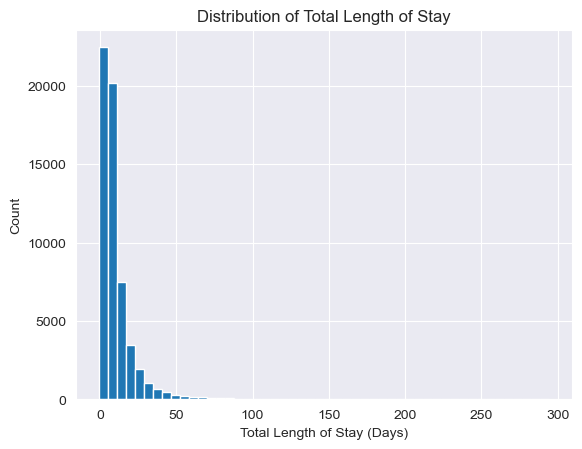

In [20]:
plt.hist(admissions['total_los'], bins=50)
plt.xlabel('Total Length of Stay (Days)')
plt.ylabel('Count')
plt.title('Distribution of Total Length of Stay')

plt.savefig(f'{img_path}03_Distribution of Total LOS.png')
plt.show()

### Total Length of Stay by Patient Outcome

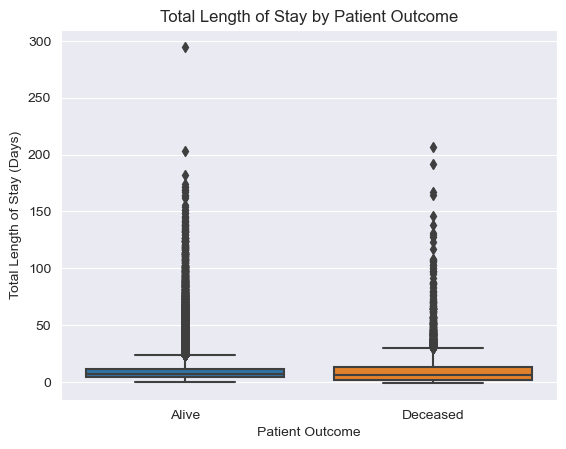

In [21]:
sns.boxplot(data=admissions, x='hospital_expire_flag', y='total_los')
plt.xlabel('Patient Outcome')
plt.ylabel('Total Length of Stay (Days)')
plt.title('Total Length of Stay by Patient Outcome')
plt.xticks([0, 1], ['Alive', 'Deceased'])

plt.savefig(f'{img_path}04_Total LOS by Patient Outcome.png')
plt.show()

# Patients

In [22]:
patients = select_table('patients', con)
patients.head()

,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag
0,234,249,F,2075-03-13,NaT,NaT,NaT,0
1,235,250,F,2164-12-27,2188-11-22,2188-11-22,NaT,1
2,236,251,M,2090-03-15,NaT,NaT,NaT,0
3,237,252,M,2078-03-06,NaT,NaT,NaT,0
4,238,253,F,2089-11-26,NaT,NaT,NaT,0


In [23]:
patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46520 entries, 0 to 46519
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   row_id       46520 non-null  int64         
 1   subject_id   46520 non-null  int64         
 2   gender       46520 non-null  object        
 3   dob          46520 non-null  datetime64[ns]
 4   dod          15759 non-null  datetime64[ns]
 5   dod_hosp     9974 non-null   datetime64[ns]
 6   dod_ssn      13378 non-null  datetime64[ns]
 7   expire_flag  46520 non-null  int64         
dtypes: datetime64[ns](4), int64(3), object(1)
memory usage: 2.8+ MB


In [24]:
# Adding patients first admission time
patients = process_patients.add_first_admission(patients, admissions)
patients.head()

,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,first_admittime
0,234,249,F,2075-03-13,NaT,NaT,NaT,0,2149-12-17
1,235,250,F,2164-12-27,2188-11-22,2188-11-22,NaT,1,2188-11-12
2,236,251,M,2090-03-15,NaT,NaT,NaT,0,2110-07-27
3,237,252,M,2078-03-06,NaT,NaT,NaT,0,2133-03-31
4,238,253,F,2089-11-26,NaT,NaT,NaT,0,2174-01-21


In [25]:
patients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46520 entries, 0 to 46519
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   row_id           46520 non-null  int64         
 1   subject_id       46520 non-null  int64         
 2   gender           46520 non-null  object        
 3   dob              46520 non-null  datetime64[ns]
 4   dod              15759 non-null  datetime64[ns]
 5   dod_hosp         9974 non-null   datetime64[ns]
 6   dod_ssn          13378 non-null  datetime64[ns]
 7   expire_flag      46520 non-null  int64         
 8   first_admittime  46520 non-null  datetime64[ns]
dtypes: datetime64[ns](5), int64(3), object(1)
memory usage: 3.5+ MB


In [26]:
# Calculating real age at first admission time
patients = process_patients.calc_age_at_admission(patients)
patients.head()

,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,first_admittime,age_at_admission
0,234,249,F,2075-03-13,NaT,NaT,NaT,0,2149-12-17,74
1,235,250,F,2164-12-27,2188-11-22,2188-11-22,NaT,1,2188-11-12,24
2,236,251,M,2090-03-15,NaT,NaT,NaT,0,2110-07-27,20
3,237,252,M,2078-03-06,NaT,NaT,NaT,0,2133-03-31,55
4,238,253,F,2089-11-26,NaT,NaT,NaT,0,2174-01-21,85


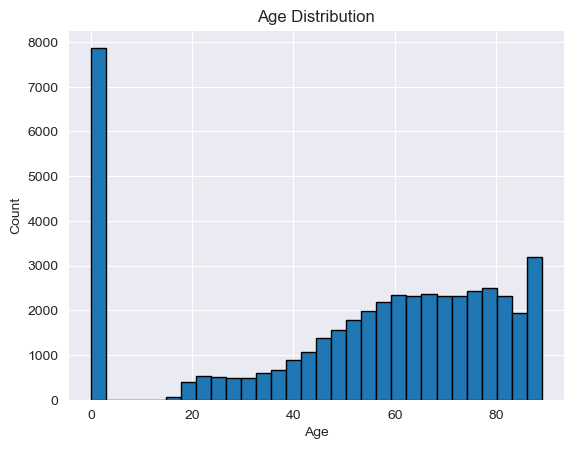

In [27]:
# Visualizing age distribution in patients table
plt.hist(patients['age_at_admission'], bins=30, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')
plt.savefig(f'{img_path}05_Age Distribution.png')
plt.show()

In [28]:
print(patients.age_at_admission.median())
print(patients.age_at_admission.mean())

60.0
52.84765692175409


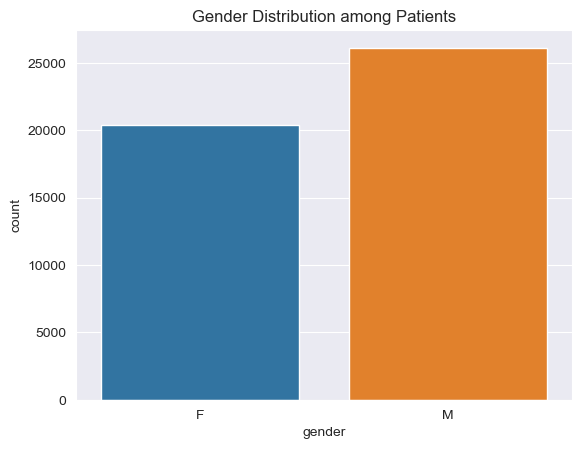

In [29]:
sns.countplot(data=patients, x='gender')
plt.title('Gender Distribution among Patients')
plt.savefig(f'{img_path}06_Gender Distribution among Patients')
plt.show()

In [30]:
# # Find the patients that died in the hospital
# deceased_subject_ids = admissions.subject_id[admissions.hospital_expire_flag == 1].tolist()
# deceased_patients_in = patients[patients.subject_id.isin(deceased_subject_ids)]
#
# # Find the patients that died outside the hospital
# deceased_patients_out = patients[(patients.expire_flag == 1) & (~patients.subject_id.isin(deceased_subject_ids))]

In [31]:
# deceased_patients_in['place_of_death'] = 'In Hospital'
# deceased_patients_out['place_of_death'] = 'Out of Hospital'
# deceased_patients = pd.concat([deceased_patients_in, deceased_patients_out])

# ICUSTAYS

In [32]:
icustays = select_table('icustays', con)
icustays.head()

,row_id,subject_id,hadm_id,icustay_id,dbsource,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202


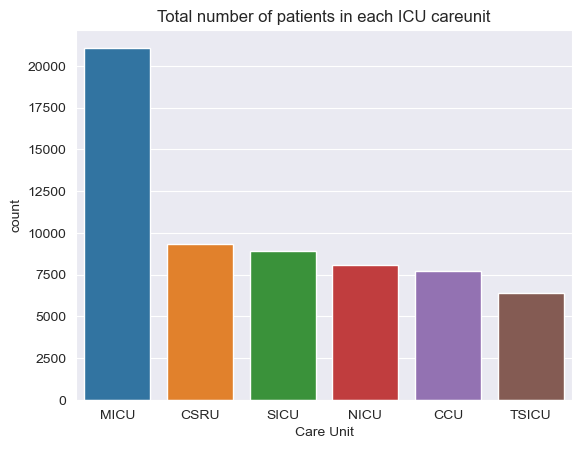

In [33]:
sns.countplot(data=icustays, x='first_careunit', order=icustays['first_careunit'].value_counts().index)
plt.title('Total number of patients in each ICU careunit')
plt.xlabel('Care Unit')
plt.savefig(f'{img_path}08_Patient Distribution in each ICU.png')
plt.show()

In [34]:
df = pd.merge(icustays, admissions[['hadm_id', 'subject_id', 'hospital_expire_flag']], on=['hadm_id', 'subject_id'], how='left')
df.head()

,row_id,subject_id,hadm_id,icustay_id,dbsource,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los,hospital_expire_flag
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490,1
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788,0
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939,0
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600,0
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202,0


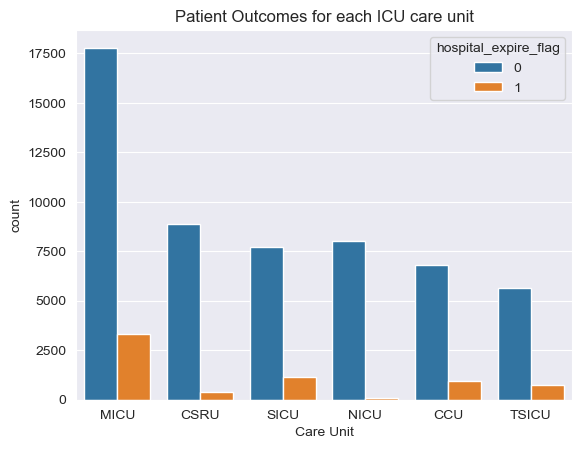

In [35]:
sns.countplot(data=df, x='first_careunit', hue='hospital_expire_flag', order=df['first_careunit'].value_counts().index)
plt.title('Patient Outcomes for each ICU care unit')
plt.xlabel('Care Unit')
plt.savefig(f'{img_path}09_Patient Outcome for each ICU.png')
plt.show()

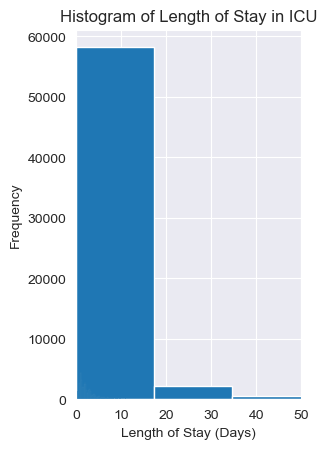

In [36]:
plt.subplot(1, 2, 1)
icustays.los.plot(kind='hist')
sns.histplot(data=icustays, x='los')

plt.xlim(0, 50)
plt.xlabel('Length of Stay (Days)')
plt.ylabel('Frequency')
plt.title('Histogram of Length of Stay in ICU')

# plt.subplot(1, 2, 2)
# sns.boxplot(data=icustays, y='los')
# plt.ylabel('Length of Stay (Days)')
# plt.ylim(0, 30)
# plt.title('Boxplot of Length of Stay in ICU')

# plt.savefig(f'{img_path}10_Length of Stay in ICU.png')
plt.show()

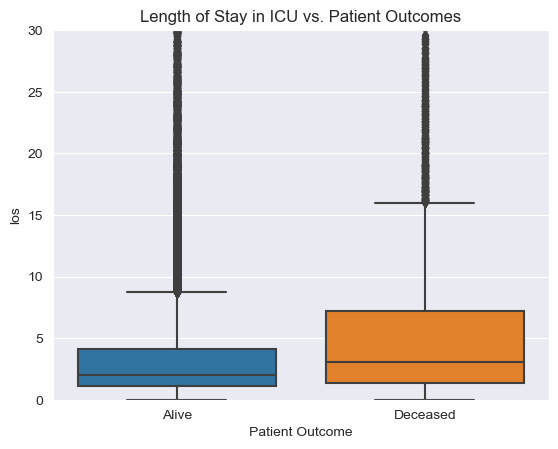

In [37]:
sns.boxplot(data=df, x='hospital_expire_flag', y='los')
plt.ylim(0, 30)
plt.title('Length of Stay in ICU vs. Patient Outcomes')
plt.xlabel('Patient Outcome')
plt.xticks([0, 1], ['Alive', 'Deceased'])
plt.savefig(f'{img_path}10_LOS in ICU by Patient Outcome.png')
plt.show()

In [38]:
# Only keep relevant features on the final version of the dataframes
admissions = process_admissions.clean_df(admissions)
patients = process_patients.clean_df(patients)
icustays = process_transfers.clean_icu(icustays)

In [39]:
admissions.head()

,subject_id,hadm_id,admittime,admission_type,admission_location,ethnicity,diagnosis,hospital_expire_flag,total_los
0,22,165315,2196-04-09 12:26:00,EMERGENCY,EMERGENCY ROOM ADMIT,WHITE,BENZODIAZEPINE OVERDOSE,0,1.14
1,23,152223,2153-09-03 07:15:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,5.50
2,23,124321,2157-10-18 19:34:00,EMERGENCY,TRANSFER,WHITE,BRAIN MASS,0,6.77
3,24,161859,2139-06-06 16:14:00,EMERGENCY,TRANSFER,WHITE,INTERIOR MYOCARDIAL INFARCTION,0,2.86
4,25,129635,2160-11-02 02:06:00,EMERGENCY,EMERGENCY ROOM ADMIT,WHITE,ACUTE CORONARY SYNDROME,0,3.53


In [40]:
patients.head()

,subject_id,gender,dob,expire_flag,age_at_admission
0,249,F,2075-03-13,0,74
1,250,F,2164-12-27,1,24
2,251,M,2090-03-15,0,20
3,252,M,2078-03-06,0,55
4,253,F,2089-11-26,0,85


In [41]:
icustays.head()

,hadm_id,icustay_id,first_careunit,icu_los
0,110404,280836,MICU,3.2490
1,106296,206613,MICU,3.2788
2,188028,220345,CCU,2.8939
3,173727,249196,MICU,2.0600
4,164716,210407,CCU,1.6202


In [42]:
df = pd.merge(admissions, patients, on='subject_id', how='left')
df = pd.merge(df, icustays, on='hadm_id', how='left')
df.head()

,subject_id,hadm_id,admittime,admission_type,admission_location,ethnicity,diagnosis,hospital_expire_flag,total_los,gender,dob,expire_flag,age_at_admission,icustay_id,first_careunit,icu_los
0,22,165315,2196-04-09 12:26:00,EMERGENCY,EMERGENCY ROOM ADMIT,WHITE,BENZODIAZEPINE OVERDOSE,0,1.14,F,2131-05-07,0,65,204798.0,MICU,1.1438
1,23,152223,2153-09-03 07:15:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,5.50,M,2082-07-17,0,71,227807.0,CSRU,1.2641
2,23,124321,2157-10-18 19:34:00,EMERGENCY,TRANSFER,WHITE,BRAIN MASS,0,6.77,M,2082-07-17,0,71,234044.0,SICU,1.1862
3,24,161859,2139-06-06 16:14:00,EMERGENCY,TRANSFER,WHITE,INTERIOR MYOCARDIAL INFARCTION,0,2.86,M,2100-05-31,0,39,262236.0,CCU,0.5124
4,25,129635,2160-11-02 02:06:00,EMERGENCY,EMERGENCY ROOM ADMIT,WHITE,ACUTE CORONARY SYNDROME,0,3.53,M,2101-11-21,0,59,203487.0,CCU,3.5466


#### Check Patient Outcome by ICU Presence

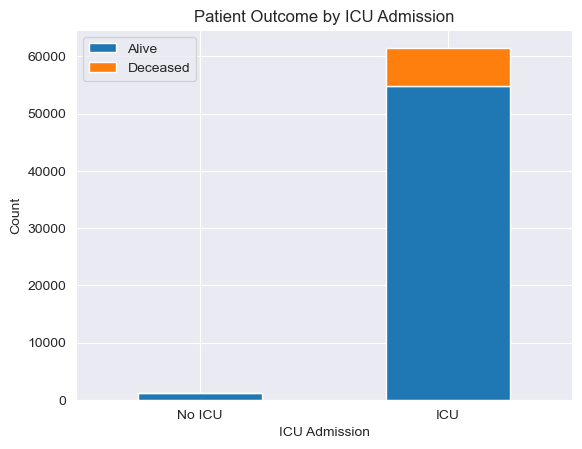

In [44]:
df['is_icu'] = df.icustay_id.apply(lambda x: 0 if pd.isnull(x) else 1)

pd.crosstab(df['is_icu'], df['hospital_expire_flag']).plot(kind='bar', stacked=True)
plt.title('Patient Outcome by ICU Admission')
plt.xlabel('ICU Admission')
plt.ylabel('Count')
plt.xticks([0, 1], ['No ICU', 'ICU'], rotation=0)
plt.legend(['Alive', 'Deceased'])
plt.savefig(f'{img_path}11_Patient Outcome by ICU Presence.png')
plt.show()

#### Calculate Age at Admission Time per each admission

In [45]:
df = process_admissions.calc_age(df)
df.head()

,subject_id,hadm_id,admittime,admission_type,admission_location,ethnicity,diagnosis,hospital_expire_flag,total_los,gender,dob,expire_flag,age_at_admission,icustay_id,first_careunit,icu_los,is_icu
0,22,165315,2196-04-09 12:26:00,EMERGENCY,EMERGENCY ROOM ADMIT,WHITE,BENZODIAZEPINE OVERDOSE,0,1.14,F,2131-05-07,0,65,204798.0,MICU,1.1438,1
1,23,152223,2153-09-03 07:15:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,5.50,M,2082-07-17,0,71,227807.0,CSRU,1.2641,1
2,23,124321,2157-10-18 19:34:00,EMERGENCY,TRANSFER,WHITE,BRAIN MASS,0,6.77,M,2082-07-17,0,75,234044.0,SICU,1.1862,1
3,24,161859,2139-06-06 16:14:00,EMERGENCY,TRANSFER,WHITE,INTERIOR MYOCARDIAL INFARCTION,0,2.86,M,2100-05-31,0,39,262236.0,CCU,0.5124,1
4,25,129635,2160-11-02 02:06:00,EMERGENCY,EMERGENCY ROOM ADMIT,WHITE,ACUTE CORONARY SYNDROME,0,3.53,M,2101-11-21,0,59,203487.0,CCU,3.5466,1


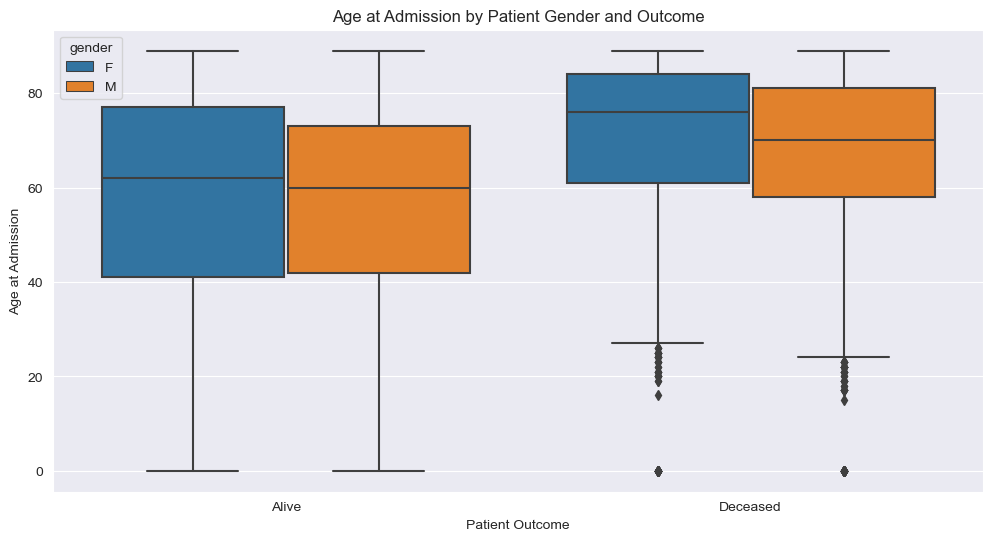

In [46]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='hospital_expire_flag', y='age_at_admission', hue='gender', data=df)
plt.xlabel('Patient Outcome')
plt.ylabel('Age at Admission')
plt.title('Age at Admission by Patient Gender and Outcome')
plt.xticks([0, 1], ['Alive', 'Deceased'])
plt.savefig(f'{img_path}07_Age at Admission by Patient Gender and Outcome')
plt.show()

In [47]:
df.drop(columns=['admittime', 'dob', 'is_icu', 'diagnosis'], inplace=True)

In [48]:
# Save the dataframe into a csv file to access it during model training
df.to_csv(f'{dataset_path}patient_stay_data.csv', index=False)

## Feature Importance

In [49]:
# # Encoding Categorical and Numerical Features
# from sklearn.preprocessing import OneHotEncoder, LabelEncoder
#
# le = LabelEncoder()
# ohe = OneHotEncoder()
#
# # For binary variables - LabelEncoder
# df['gender'] = le.fit_transform(df['gender']) # Male and Female can be represented as 0 and 1
#
# # For nominal variables - OneHotEncoder
# nominal_features = ['admission_type', 'admission_location', 'ethnicity', 'first_careunit']
# for feature in nominal_features:
#     encoded_features = ohe.fit_transform(df[feature].values.reshape(-1, 1)).toarray()
#     feature_labels = ohe.categories_
#     encoded_labels = [f'{feature}_{label}' for label in feature_labels[0]]
#     df_encoded = pd.DataFrame(encoded_features, columns=encoded_labels)
#     df = pd.concat([df, df_encoded], axis=1)
#
#
# # For numerical features - handle missing values
# df['total_los'].fillna(0, inplace=True)
# df['icu_los'].fillna(0, inplace=True)
#
# df.drop(columns=nominal_features + ['gender'], inplace=True)
# df.drop(columns=['hadm_id', 'subject_id', 'icustay_id', 'diagnosis', 'expire_flag'], inplace=True)

In [50]:
# print(df.head())

In [51]:
# # Applying Feature Importance using Random Forest
# rf_importance, rf_accuracies = apply_feature_importance.get_feature_importance(df=df, classifier='rf')
#
# for feature, importance in rf_importance:
#     print(f"Feature: {feature}, Importance: {importance}")

In [52]:
# for acc_type, value in rf_accuracies.items():
#     print(f"{acc_type}: {value}")

In [53]:
# xgb_importance, xgb_accuracies = apply_feature_importance.get_feature_importance(df=df, classifier='xgb')
#
# for feature, importance in xgb_importance:
#     print(f"Feature: {feature}, Importance: {importance}")

In [54]:
# for acc_type, value in xgb_accuracies.items():
#     print(f"{acc_type}: {value}")

In [55]:
# from sklearn.model_selection import train_test_split
# X = df.drop(columns=['hospital_expire_flag'])
# y = df['hospital_expire_flag']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [56]:
# ## Apply Feature Importance using SelectKBest
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2
#
# kbest = SelectKBest(score_func=chi2, k=10)
#
# fit = kbest.fit(X, y)
#
# # Get the scores associated with each feature
# np.set_printoptions(precision=3)
# print(fit.scores_)
#
# X_new = fit.transform(X)
#
# mask = kbest.get_support()
# new_features = [] # The list of the K best features
#
# for bool, feature in zip(mask, X.columns):
#     if bool:
#         new_features.append(feature)
# print(new_features)